# Литература
* Статьи ребят из expf:
[раз](https://medium.com/statistics-experiments/%D0%BA%D0%BE%D0%B3%D0%B4%D0%B0-%D0%BE%D1%81%D1%82%D0%B0%D0%BD%D0%B0%D0%B2%D0%BB%D0%B8%D0%B2%D0%B0%D1%82%D1%8C-a-b-%D1%82%D0%B5%D1%81%D1%82-%D1%87%D0%B0%D1%81%D1%82%D1%8C-1-mde-7d39b668b488) и [два](https://medium.com/statistics-experiments/%D0%BA%D0%BE%D0%B3%D0%B4%D0%B0-%D0%BE%D1%81%D1%82%D0%B0%D0%BD%D0%B0%D0%B2%D0%BB%D0%B8%D0%B2%D0%B0%D1%82%D1%8C-a-b-%D1%82%D0%B5%D1%81%D1%82-%D1%87%D0%B0%D1%81%D1%82%D1%8C-2-monte-carlo-a342ba5b552c)   

* Доклады Толи Карпова:
[раз](https://www.youtube.com/watch?v=2nP_gcut7SU) и [два](https://www.youtube.com/watch?v=lJY6eMh10iE)   

* [Эван Миллер. Почему разные онлайн калькуляторы дают разные результаты](https://www.linkedin.com/posts/evanmmiller_today-we-discuss-ab-sample-size-formulas-activity-6980615725342179328-hNu6/)

* [Расчет мощности в statsmodels](https://www.statmethods.net/stats/power.html)
* [Тут брал формулы для пропорций](https://craptalks.com/blog/2021/04/part-2-minimum-detectable-effect-as-a-function-of-sample-size/)
* [Чуть более подробно](https://towardsdatascience.com/required-sample-size-for-a-b-testing-6f6608dd330a)
* [Что такое размер эффекта](https://en.wikipedia.org/wiki/Effect_size)
* [What is the relationship between a chi squared test and test of equal proportions?](https://stats.stackexchange.com/questions/2391/what-is-the-relationship-between-a-chi-squared-test-and-test-of-equal-proportion)
* [Как определить размер выборки для бутстрэпа старым дедовским способом](https://habr.com/ru/amp/publications/707816/)


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import seaborn as sns
import math
from scipy.stats import norm, ttest_ind
from statsmodels.stats.proportion import proportions_ztest

# Размер выборки (sample size) и минимальный детектируемый эффект (MDE) для сравнения  средних значений

Рассмотрим гипотезу о равенстве средних

$H_0: \mu_X = \mu_Y$

против альтернативной

$H_1: \mu_X \neq \mu_Y$


$$n = \dfrac{\left[ \Phi^{-1}\Bigl( 1-\dfrac{\alpha}{2} \Bigr) + \Phi^{-1} \Bigl( 1-\beta \Bigr) \right]^2 (\sigma_X^2 + \sigma_Y^2)}{\Delta^2}$$


$$\Delta = \frac{\left[ \Phi^{-1} \left( 1-\dfrac{\alpha}{2} \right) + \Phi^{-1} \left( 1-\beta \right) \right] \sqrt{ \sigma_X^2 + \sigma_Y^2 }}{\sqrt{n}}$$

${\alpha}$ − вероятность ошибки первого рода, она же уровень значимости

${\beta}$ − вероятность ошибки второго рода

$\sigma_X , \sigma_Y$  − стандартные отклонения в контрольной и экспериментальной группах соответственно. Эти значения можно оценить по историческим данным.

$\Delta = \mu_X - \mu_Y$ − ожидаемый эффект - эффект, который мы ожидаем получить от эксперимента

$\Phi^{-1}$ − Обратная функция нормального распределения

Для ${\alpha} = 0.05,  \Phi^{-1} \Bigl( 1-\dfrac{\alpha}{2}\Bigr) = 1.96$,

Для ${\beta} = 0.1,  \Phi^{-1} \Bigl( 1-\beta \Bigr) = 1.28$

Реализация формулы для случая **равных дисперсий и двустороннего теста** (для одностороннего  заменить  $\Phi^{-1} \Bigl( 1-\dfrac{\alpha}{2}\Bigr)$  на $\Phi^{-1} \Bigl( 1-{\alpha}\Bigr)$:

In [15]:
#   Для абсолютного изменения
def get_sample_size_abs(delta, std, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (2 * std ** 2) / (delta ** 2)
        )
    )
    return sample_size

#   Для относительного изменения
def get_sample_size_arb(mu, std, eff, alpha=0.05, beta=0.2):
    delta = (eff - 1) * mu
    return get_sample_size_abs(delta, std=std, alpha=alpha, beta=beta)

# MDE
def get_minimal_detectable_effect(std, sample_size, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    disp_sum_sqrt = (2 * (std ** 2)) ** 0.5
    mde = (t_alpha + t_beta) * disp_sum_sqrt / np.sqrt(sample_size)
    return mde

###  Есть и готовая реализация

In [16]:
from statsmodels.stats.power import tt_ind_solve_power 

### Пример

In [17]:
mu = 300
std = 150
eff = 1.05
alpha = 0.05
beta = 0.2

In [18]:
sample_size_1 = get_sample_size_arb(mu=mu, 
                                    std=std, 
                                    eff=eff,
                                    alpha=alpha, 
                                    beta=beta)

standardized_effect_size = (eff - 1) * mu / std
sample_size_2 = tt_ind_solve_power(effect_size=standardized_effect_size,
                                    nobs1=None,
                                    alpha=alpha,
                                    power=1-beta,
                                    ratio=1.0,
                                    alternative='two-sided')


print(f'sample_size get_sample_size = {sample_size_1}')
print(f'sample_size statsmodels = {sample_size_2:1.0f}\n')


sample_size = sample_size_1

mde_1 = get_minimal_detectable_effect(std=std, 
                                        sample_size=sample_size,
                                        alpha=alpha, 
                                        beta=beta)

mde_2 = tt_ind_solve_power(effect_size=None,
                           nobs1=sample_size,
                           alpha=alpha,
                           power=1-beta,
                           ratio=1.0,
                           alternative='two-sided')
mde = mde_1

print(f'mde get_minimal_detectable_effect = {mde_1:0.4f}')
print(f'mde statsmodels = {mde_2*std:0.4f}\n')

sample_size get_sample_size = 1570
sample_size statsmodels = 1571

mde get_minimal_detectable_effect = 14.9989
mde statsmodels = 15.0036



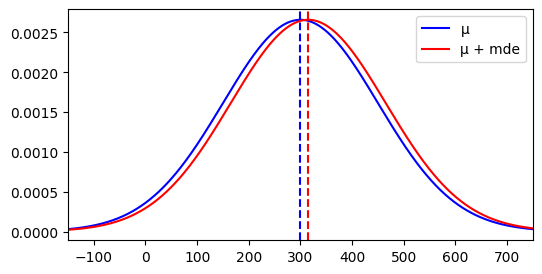

In [19]:
x = np.linspace(mu - 3*std, mu + 3*std, 10000)

a = norm.pdf(x, loc=mu, scale=std)
b = norm.pdf(x, mu+mde, scale=std)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))

sns.lineplot(x=x, y=a, ax=ax, color='blue', label='μ')
ax.axvline(x=mu, linestyle='--', color='blue')

sns.lineplot(x=x, y=b, ax=ax, color='red', label='μ + mde')
ax.axvline(x=mu+mde, linestyle='--', color='red')

x_min = mu - 3*std
x_max = mu + 3*std

ax.set_xlim(x_min, x_max)

plt.show()

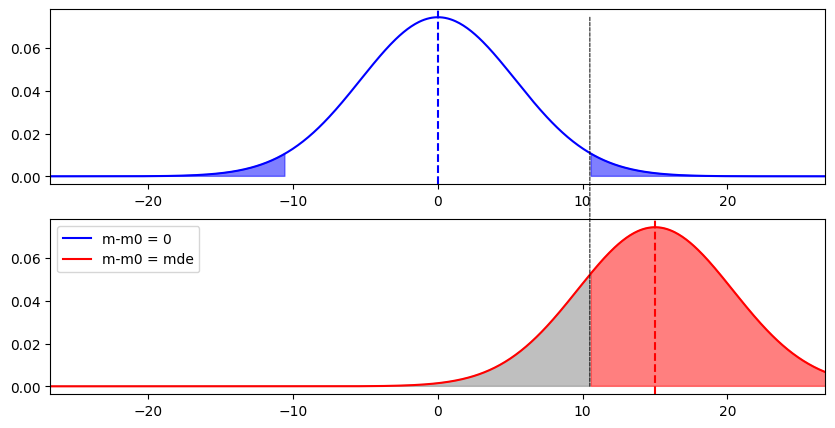

In [20]:
sem = (4*std**2 / (sample_size*2))**0.5

a_q = norm.ppf(q=1-alpha/2, loc=0, scale=sem)
b_q = norm.ppf(q=beta, loc=mde, scale=sem)

a = norm.pdf(x, loc=0, scale=sem)
b = norm.pdf(x, loc=mde, scale=sem)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

l1 = sns.lineplot(x=x, y=a, ax=ax1, color='blue')
ax1.axvline(x=0, linestyle='--', color='blue')
ax1.fill_between(x, a, where=x>a_q, alpha=0.5, color = 'b')
ax1.fill_between(x, a, where=x<-a_q, alpha=0.5, color = 'b')

l2 = sns.lineplot(x=x, y=b, ax=ax2, color='red')
ax2.axvline(x=mde, linestyle='--', color='red')
ax2.fill_between(x, b, where=x>b_q, color='red', alpha=0.5)
ax2.fill_between(x, b, where=x<b_q, color='grey', alpha=0.5)

x_min = 0 - 5*sem
x_max = 0 + 5*sem
ax1.set_xlim(x_min, x_max)
ax2.set_xlim(x_min, x_max)


plt.legend(labels = ['m-m0 = 0', 'm-m0 = mde'], 
         handles=[l1.get_lines()[0], l2.get_lines()[0]])


xy_a = (a_q, max(a))
xy_b = (b_q, 0)
con = ConnectionPatch(xyA=xy_a, coordsA=ax1.transData,
                      xyB=xy_b, coordsB=ax2.transData)
con.set_linewidth(0.7)
con.set_linestyle('dashed')
fig.add_artist(con)
plt.show()

# Размер выборки (sample size) и минимальный детектируемый эффект (MDE) для сравнения  пропорций

Рассмотрим гипотезу о равенстве средних

$H_0: p_X = p_Y$

против альтернативной

$H_1: p_X \neq p_Y$


$$n = \dfrac{\left[ \Phi^{-1} \Bigl( 1-\dfrac{\alpha}{2} \Bigr) + \Phi^{-1} \Bigl( 1-\beta \Bigr) \right]^2 (p_X*(1-p_X) + p_Y*(1-p_Y))}{\Delta^2}$$

${\alpha}$ − вероятность ошибки первого рода, она же уровень значимости

${\beta}$ − вероятность ошибки второго рода

$p_X*(1-p_X) , p_Y*(1-p_Y)$  − дисперсии в контрольной и экспериментальной группах соответственно

$\Delta = p_X - p_Y$ − ожидаемый эффект - эффект, который мы ожидаем получить от эксперимента

$\Phi^{-1}$ − Обратная функция нормального распределения

Для ${\alpha} = 0.05,  \Phi^{-1} \Bigl( 1-\dfrac{\alpha}{2}\Bigr) = 1.96$,

Для ${\beta} = 0.1,  \Phi^{-1} \Bigl( 1-\beta \Bigr) = 1.28$

Реализация формулы для случая **двустороннего теста** (для одностороннего  заменить  $\Phi^{-1} \Bigl( 1-\dfrac{\alpha}{2}\Bigr)$  на $\Phi^{-1} \Bigl( 1-{\alpha}\Bigr)$

Для получения MDE для пропорций сразу используем готовое решение

In [21]:
#   Для абсолютного изменения
def get_sample_size_abs(p, delta, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    var = (p * (1 - p)) + ((p + delta) * (1 - (p + delta))) 
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * var / (delta ** 2)
        )
    )
    return sample_size

#   Для относительного изменения
def get_sample_size_arb(p, eff, alpha=0.05, beta=0.2):
    delta = (eff - 1) * p
    return get_sample_size_abs(p=p, delta=delta, alpha=alpha, beta=beta)

###  Есть и готовая реализация

In [22]:
from statsmodels.stats.power import zt_ind_solve_power

### Пример

In [23]:
p = 0.3
eff = 1.1
alpha = 0.05
beta = 0.2

In [24]:
sample_size_1 = get_sample_size_arb(p=p,  
                                    eff=eff,
                                    alpha=0.05, 
                                    beta=0.2)

standardized_effect_size = 2 * (np.arcsin(np.sqrt(p)) - np.arcsin(np.sqrt(p*eff)))
sample_size_2 = zt_ind_solve_power(effect_size=standardized_effect_size,
                                    nobs1=None,                                   
                                    alpha=alpha,
                                    power=1-beta,
                                    ratio=1.0,
                                    alternative='two-sided'
                                  )

print('sample_size:')
print(f'get_sample_size = {sample_size_1}', f'statsmodels = {sample_size_2:1.0f}', sep = '\n', end = '\n\n')


sample_size = sample_size_1


mde = zt_ind_solve_power(effect_size=None,
                           nobs1=sample_size,
                           alpha=alpha,
                           power=1-beta,
                           ratio=1.0,
                           alternative='two-sided')

#  Пакет statsmodels возвращает стандартизированное
#  значение MDE (долю от среднеквадратичного отклонения)
mde_abs = mde * (np.sqrt(p * (1 - p)))
print('mde:')
print(f'statsmodels = {mde_abs:0.5f}', sep ='\n', end='\n')

sample_size:
get_sample_size = 3760
statsmodels = 3762

mde:
statsmodels = 0.02961


In [13]:
def check_ztest(a, b, alpha=0.05):
    _, pvalue = proportions_ztest([sum(a), sum(b)], [len(a), len(b)], value=0)
    return int(pvalue < alpha)

print(f'mde = {mde}\n')
print('Ошибки I и II рода:')
for _ in range(5):
    result_aa = []
    result_ab = []
    for _ in range(5000):
        a_one = np.random.binomial(n=1, p=p, size=sample_size)
        a_two = np.random.binomial(n=1, p=p, size=sample_size)
        b = np.random.binomial(n=1, p=p + mde_abs, size=sample_size)
        result_aa.append(check_ztest(a_one, a_two, alpha=alpha))
        result_ab.append(check_ztest(a_one, b, alpha=alpha))

    error_first = np.mean(result_aa)
    error_second = 1 - np.mean(result_ab)
    print(f'  {error_first:0.3f} \t{error_second:0.3f}')

mde = 0.06461365653606967

Ошибки I и II рода:
  0.050 	0.207
  0.052 	0.211
  0.051 	0.209
  0.046 	0.207
  0.051 	0.210
